In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 464 kB/s 
     |████████████████████████████████| 5.8 MB 58.9 MB/s 
     |████████████████████████████████| 1.3 MB 58.3 MB/s 
     |████████████████████████████████| 182 kB 72.4 MB/s 
     |████████████████████████████████| 7.6 MB 25.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=75ba364ee24ff38d8d6e083ff4111b402d38d3eacc5410a911b14eb3943d1213
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os
import numpy as np
import gzip
import json
import pandas as pd
from scipy.cluster.vq import *

Load data from gzip json files

In [ ]:
def load_data(file_name, head = 500000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [ ]:
children = load_data(os.path.join("./", '/content/drive/MyDrive/Data/goodreads_books_children.json.gz'))
child_df=pd.DataFrame.from_records(children)

We have identified some common popular genres from popular_shelves column of bookd daatframe and stored it in child_genres list. We perform one hot encoding the match the genres which is present for every single book.

In [ ]:
child_genres=["classic",'favorite','fiction','children','fantasy','young-adult','childhood','kids','adventure','animal','school','picture-books','library','other']
def apply_genre(r):
  encode=["0"]*len(child_genres)
  for val in r['popular_shelves']:

    for idx,g in enumerate(child_genres):
      if val['name'] in g:
        encode[idx]="1"
  return "".join(encode)

child_df["genre"]=child_df.apply(lambda row: apply_genre(row), axis=1)
child_df["genre"]=child_df["genre"].astype(str)
child_df["genre_len"]=child_df["genre"].apply(lambda x: len(x))
child_df.head(3)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,genre,genre_len
0,1599150603,7,[],US,,"[{'count': '56', 'name': 'to-read'}, {'count':...",,false,4.13,B00DU10PUG,...,2006,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,287141,46,278578,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls,10011000001000,14
1,1934876569,6,[151854],US,,"[{'count': '515', 'name': 'to-read'}, {'count'...",,false,4.22,,...,2009,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,6066812,98,701117,All's Fairy in Love and War (Avalon: Web of Ma...,All's Fairy in Love and War (Avalon: Web of Ma...,11111111110111,14
2,0590417010,193,[],US,eng,"[{'count': '450', 'name': 'to-read'}, {'count'...",,false,4.43,B017RORXNI,...,1995,https://www.goodreads.com/book/show/89378.Dog_...,https://images.gr-assets.com/books/1360057676m...,89378,1331,86259,Dog Heaven,Dog Heaven,11111111111110,14


Accessing preprocessed data

In [ ]:
import pandas as pd 
final_df=pd.read_csv("/content/drive/MyDrive/Data/final_data.csv")
child_books=child_df

In [ ]:
child_books["genre"]=child_books["genre"].astype(str)
books_genre=child_books.set_index('book_id').to_dict()['genre']


Every book will have multiple user rating and multiple reviews from different users. So we aggregate those reviews and join them togehter and we take a mean of the user ratings.

In [ ]:
final_df["book_genre"]=final_df["book_id"].apply(lambda x:books_genre.get(str(x), "00000000000000"),0)
final_df.dropna(inplace=True)
grouped_df = final_df.groupby(['language_code', 'is_ebook','average_rating','similar_books','description'
,'publisher','title','book_id','book_genre','author_ids','n_votes'
]).agg({'rating': 'mean','review_text':' '.join}).reset_index()


In [ ]:
grouped_df["review_length"]=grouped_df["review_text"].apply(lambda x: len(x))
grouped_df["description_len"]=grouped_df["description"].apply(lambda x: len(x))
grouped_df=grouped_df[grouped_df["language_code"].isin(["eng","en-US","en-GB"])]
grouped_df.head(2)

,language_code,is_ebook,average_rating,similar_books,description,publisher,title,book_id,book_genre,author_ids,n_votes,rating,review_text,review_length,description_len
2068,en-GB,False,2.60,[],Big Pig's Sister and her friend have been to t...,Hodder Children's Books,Wibbly Pig and the Tooky,18586838,00010001000000,['77009'],0.0,3.0,"Cute, especially the pictures. Would have like...",290,113
2069,en-GB,False,2.67,[],"Imagine Tirion's feelings: ten years old, and ...",Pont,Tirion's Secret Journal,11136325,00000000000000,['42859'],0.0,3.0,"Very cute, and nicely informative too - loads ...",605,452


In [ ]:
final_df["book_genre"].value_counts()

11111111101110    18020
00111111100110    11916
00110001000110     9987
10111111101110     7794
00111100101101     7230
                  ...  
10111110001110        1
01101100001000        1
01010000101100        1
00111001110001        1
10011101000110        1
Name: book_genre, Length: 2520, dtype: int64

The following plot shows that the length of most of book descriptions are lying mostly around 1000 characters, while few of them being as high as 16000 characters

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


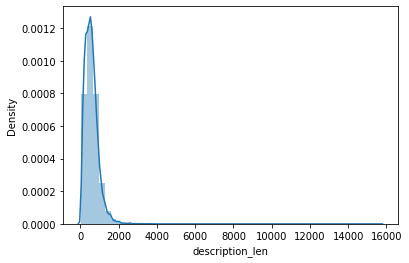

In [ ]:

grouped_df["description_len"].max()
import seaborn as sns
sns.distplot(grouped_df['description_len'])

In [ ]:
grouped_df["review_text"] = grouped_df["review_text"].fillna('')
grouped_df["description"] = grouped_df["description"].fillna('')
grouped_df["publisher"] = grouped_df["publisher"].fillna('')
grouped_df["title"] = grouped_df["title"].fillna('')

We combine these rows together to "combined" column and this column is going to have all the aggregated data of every single book. So each entry of this column acts like a single document containing all the information of a book.

In [ ]:
def combine(r):
  return r['publisher']+' '+r['title']+' '+r['author_ids']+' '+str(r['average_rating'])+' '+r['book_genre']+' '+r['description']+' '+r['review_text']

In [ ]:
grouped_df["combined"] =grouped_df.apply(combine, axis = 1)

In [ ]:
# grouped_df=pd.read_csv("/content/drive/MyDrive/Data/grouped_df.csv",dtype=str)
grouped_df=grouped_df[1:25000]

In [ ]:
grouped_df.head(5)

,language_code,is_ebook,average_rating,similar_books,description,publisher,title,book_id,book_genre,author_ids,n_votes,rating,review_text,review_length,description_len,combined
2070,en-GB,False,2.68,[],A picture book retelling of a traditional Euro...,Kregel Publications,Simon and the Easter Miracle,10454659,00010000000100,"['211681', '892038']",0.0,2.714286,Simon and the Easter Miracle is a traditional ...,13684,643,Kregel Publications Simon and the Easter Mirac...
2071,en-GB,False,2.78,[],"The call to self expression haunts a delicate,...",Candlewick Press,The Girl Who Wanted to Dance,6073626,00010001000100,"['6382', '2773385']",0.0,4.500000,This is a beautiful and sweet story about a gi...,311,727,Candlewick Press The Girl Who Wanted to Dance ...
2072,en-GB,False,2.79,[],"Owls are supposed to be wise, but Twoo Twit is...",Hodder Children's Books,Twoo Twit,2287255,00000001001110,['49142'],0.0,3.500000,Cute \n Note for self - Church and pastor ment...,98,198,Hodder Children's Books Twoo Twit ['49142'] 2....
2073,en-GB,False,2.79,[],"Owls are supposed to be wise, but Twoo Twit is...",Hodder Children's Books,Twoo Twit,2287255,00000001001110,['49142'],1.0,0.000000,First read to Ivy 19/06/2016 \n Moral: If you ...,129,198,Hodder Children's Books Twoo Twit ['49142'] 2....
2074,en-GB,False,2.90,[],"Charlie is visiting the beach with his dad, wh...",Hodder General Publishing Division,The Biggest Hole In The World,520674,00110000100100,"['289000', '2824279']",0.0,2.000000,Who hasn't thought about the possibility of di...,1689,370,Hodder General Publishing Division The Biggest...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
  
# Vectorizing pre-processed movie plots using TF-IDF
tfidfvec = TfidfVectorizer()
tfidf_movieid = tfidfvec.fit_transform((grouped_df["combined"]))
  

# Finding cosine similarity between vectors


In [ ]:
tfidf_movieid

<9999x82475 sparse matrix of type '<class 'numpy.float64'>'
	with 2262252 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100).fit(tfidf_movieid)

In [ ]:
grouped_df["clusters"]=kmeans.labels_

In [ ]:
def index(title):
    return grouped_df[grouped_df.title == title]["S_no"].values[0]

In [ ]:
grouped_df.reset_index(inplace=True)
indices = pd.Series(grouped_df.index)

def recommendations(title):
    recommended_movies = []
    genre=[]
    index = grouped_df[grouped_df.title==title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top_10_movies = list(similarity_scores.iloc[1:11].index)
    for i in top_10_movies:
        try:
          recommended_movies.append(list(grouped_df.title)[i])
          genre.append(list(grouped_df.book_genre)[i])
        except:
          print("not found")
    return recommended_movies,genre

In [ ]:
recommendations("Forever X")


In [ ]:
#Calculate relevance of document based on matching number of book genres
def relevance(predicted,expected,total):
  child_genres=["classic",'favorite','fiction','children','fantasy','young-adult','childhood','kids','adventure','animal','school','picture-books','library','other']
  baseline=sum([1 for i in expected if i=="1"])
  rel_score=[]
  for p in predicted[:total]:
    score=0
    for idx,p in enumerate(p):
      if expected[idx]==p and p=="1":score+=1
    rel_score.append(score/(baseline+0.01)*1)
  return rel_score

#calculate precision with a threshold of 0.4
def precision(relevance_score):
  return sum([1 for i in relevance_score if i>0.5])/len(relevance_score)


In [ ]:
def calculate_score(total=10):
  score=[]
  for row,d in grouped_df.iterrows():
    name=d["title"]
    desc=d["description"]
    #concatenate book name and description and get document embedding for the same
    result=recommendations(name)
    book_g=d["book_genre"]
    similar_books = getElementsInTheSameCluster(d["clusters"])
    similar_books=list(set(similar_books['genre']))
    # similar_books=list(set(similar_books['genre']))
    #calculate precision@total
    relevance_score=relevance(similar_books,book_g,total)
    prec=precision(relevance_score)
    score.append(prec)
  return sum(score)/len(score)
  

In [ ]:
def getElementsInTheSameCluster(centroid):
    cluster =grouped_df
    cluster['embeddings_id'] = [i for i in range(0,9999)]
    multiIndex_cluster = cluster.sort_values(by=['clusters'])
    multiIndex_cluster = multiIndex_cluster.set_index(['clusters'])
    books = multiIndex_cluster.loc[centroid]

    ids = np.asarray(books.index)
    titles = [t for t in books['title']]
    genre=[t for t in books['book_genre']]
    description = [d for d in books['description']]
    similar_books = {'id':ids, 'title':titles, 'description':description,'genre':genre}
    return similar_books

In [ ]:
result=calculate_score(5)
print("Precision @5: ",result)

Precision @5:  0.7113794712804994


In [ ]:
result=calculate_score(10)
print("Precision @10: ",result)

Precision @10:  0.7209356649950743


In [ ]:
result=calculate_score(25)
print("Precision @25: ",result)

Precision @25:  0.6882396452808519
